In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("../")
from read_tfrecords import OccnetTfrecordLoader
from models.research.keypointnet.main import Transformer
# from models.research.keypointnet.main import *

In [2]:
import cv2
import math

In [3]:
sess = tf.Session()

In [4]:
vw, vh = 128, 128

In [5]:
occnet_dataloader = OccnetTfrecordLoader("../datasets/00004/", occnet_data=True)
occnet_transformer = Transformer(128, 128, "../datasets/00004/", occnet=True)
occnet_features = occnet_dataloader.get_features()
# features = sess.run(features)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [6]:
a = tf.constant([
        [
        [1,2,3,4],
        [5,6,7,8],
        [9,10,11,12],
        [13,14,15,16]
        ]
    ]
)

# world coordinates
# [batch, num_kp, 3]
uvzw = tf.constant([
        [
        [1,1,1,1],
        [5,6,7,8]
        ]
    ]
)

In [32]:
sess.run(tf.matmul(uvzw, a))

array([[[ 28,  32,  36,  40],
        [202, 228, 254, 280]]], dtype=int32)

In [30]:
sess.run(tf.transpose(a, [0, 2, 1]))

array([[[ 1,  5,  9, 13],
        [ 2,  6, 10, 14],
        [ 3,  7, 11, 15],
        [ 4,  8, 12, 16]]], dtype=int32)

In [33]:
sess.run(
    tf.matmul(
        uvzw, 
        tf.transpose(a, [0, 2, 1])
    )
)

array([[[ 10,  26,  42,  58],
        [ 70, 174, 278, 382]]], dtype=int32)

In [121]:
b = tf.transpose(a, [0, 2, 1])

In [122]:
sess.run(a)

array([[[ 1,  2,  3,  4],
        [ 5,  6,  7,  8],
        [ 9, 10, 11, 12],
        [13, 14, 15, 16]]], dtype=int32)

In [123]:
sess.run(b)

array([[[ 1,  5,  9, 13],
        [ 2,  6, 10, 14],
        [ 3,  7, 11, 15],
        [ 4,  8, 12, 16]]], dtype=int32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


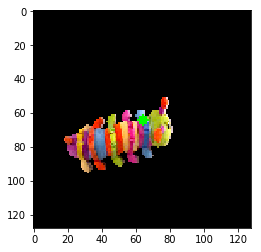

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


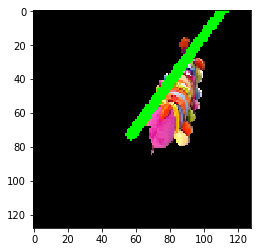

In [14]:
def func1(x):
    return tf.transpose(tf.reshape(occnet_features[x], [-1, 4, 4]), [0, 2, 1])
#     return tf.reshape(occnet_features[x], [-1, 4, 4])

mv = [func1("mv%d" % i) for i in range(2)]
mvi = [func1("mvi%d" % i) for i in range(2)]
img0_depth = tf.reshape(occnet_features["img0_depth"], [-1, 480, 640])

u, v = 0.0, 0.0
points = []
for z in np.linspace(-0.5, 0.5, num=100):
    z_value = (img0_depth[0, 240, 320] / 1000.0) + z
    points.append([u, v, z_value])
    
uvz = tf.expand_dims(tf.convert_to_tensor(points), axis=0)

world_coords = tf.matmul(occnet_transformer.unproject(uvz), mvi[0])
uvz_proj = occnet_transformer.project(tf.matmul(world_coords, mv[1 - 0]))
# world_coords = tf.matmul(occnet_transformer.unproject(uvz), mv[0])
# uvz_proj = occnet_transformer.project(tf.matmul(world_coords, mvi[1 - 0]))

# trans = tf.matmul(mvi[1-0], mv[0])
# trans = tf.matmul(
#     tf.transpose(mvi[1-0], [0, 2, 1]),
#     tf.transpose(mv[0], [0, 2, 1])
# )
# homogenous_world_coords = occnet_transformer.unproject(uvz)
# new_homogenous_world_coords = tf.matmul(trans, tf.transpose(homogenous_world_coords, [0, 2, 1]))
# new_homogenous_world_coords = tf.transpose(new_homogenous_world_coords, [0, 2, 1])
# uvz_proj = occnet_transformer.project(new_homogenous_world_coords)


# world_coords = tf.matmul(
#     tf.matmul(
#         occnet_transformer.unproject(uvz),
#         mvi[0]
#     ),
#     mv[1 - 0]
# )
# world_coords = tf.transpose(
#     tf.matmul(
#         trans,
#         tf.transpose(occnet_transformer.unproject(uvz), [0, 2, 1])
#     ),
#     [0, 2, 1]
# )
# uvz_proj = occnet_transformer.project(world_coords)
    
    
    
uvz, uvz_proj, img0, img1, img0_depth = sess.run(
    [
        uvz,
        uvz_proj,
        occnet_features["img0"][0, :, :, :3],
        occnet_features["img1"][0, :, :, :3],
        img0_depth
    ]
)

# draw on the image
x = int((u + 1.0) * 64.0)
y = int((v + 1.0) * 64.0)
new_img0 = cv2.circle(img0.copy(), (x, y), 3, (0, 255, 0), -1)
plt.imshow(new_img0)
plt.show()

new_img1 = img1.copy()
for index, point in enumerate(uvz_proj[0]):
#     print(index)
#     print(point)
    try:
        u, v, z = point
        
        x = int((u + 1.0) * 64.0)
        y = int((v + 1.0) * 64.0)
        
        # this code flips our projections
#         x = (min(max(u, -1), 1) * vw / 2 + vw / 2) - 0.5
#         y = vh - 0.5 - (min(max(v, -1), 1) * vh / 2 + vh / 2)
#         if math.isnan(x) or math.isnan(y):
#             pass

#         x = int(round(x))
#         y = int(round(y))

        new_img1 = cv2.circle(new_img1, (x, y), 3, (0, 255, 0), -1)
    except:
        pass

plt.imshow(new_img1)
plt.show()

# plt.imshow(img0_depth[0])
# plt.show()


In [16]:
keypointnet_dataloader = OccnetTfrecordLoader("../../data/cars_with_keypoints/", occnet_data=False)
keypointnet_transformer = Transformer(128, 128, "../../data/cars_with_keypoints/", occnet=False)
keypointnet_features = keypointnet_dataloader.get_features()
# keypointnet_features = sess.run(keypointnet_features)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


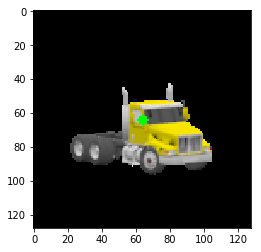

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


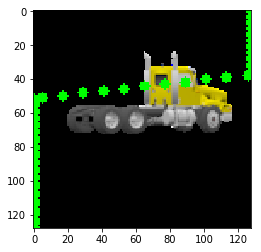

In [17]:
def func1(x):
    return tf.transpose(tf.reshape(keypointnet_features[x], [-1, 4, 4]), [0, 2, 1])

mv = [func1("mv%d" % i) for i in range(2)]
mvi = [func1("mvi%d" % i) for i in range(2)]

u, v = 0.0, 0.0
points = []
for z in np.linspace(-50.0, 0.0, num=200):
    points.append([u, v, z])
    
uvz = tf.constant([points])

world_coords = tf.matmul(keypointnet_transformer.unproject(uvz), mvi[0])
uvz_proj = keypointnet_transformer.project(tf.matmul(world_coords, mv[1 - 0]))

uvz, uvz_proj, img0, img1 = sess.run(
    [
        uvz,
        uvz_proj,
        keypointnet_features["img0"][0, :, :, :3],
        keypointnet_features["img1"][0, :, :, :3]
    ]
)

# draw on the image
x = int((u + 1.0) * 64.0)
y = int((v + 1.0) * 64.0)
new_img0 = cv2.circle(img0.copy(), (x, y), 3, (0, 255, 0), -1)
plt.imshow(new_img0)
plt.show()

new_img1 = img1.copy()
for index, point in enumerate(uvz_proj[0]):
#     print(index)
#     print(point)

    u, v, z = point
    # ---
#     x = int((u + 1.0) * 64.0)
#     y = 128 - int((v + 1.0) * 64.0)
    # OR
    x = (min(max(u, -1), 1) * vw / 2 + vw / 2) - 0.5
    y = vh - 0.5 - (min(max(v, -1), 1) * vh / 2 + vh / 2)
    x = int(round(x))
    y = int(round(y))
    
    new_img1 = cv2.circle(new_img1, (x, y), 3, (0, 255, 0), -1)

plt.imshow(new_img1)
plt.show()
